In [1]:
import pandas as pd

# Load the Excel file into a DataFrame
data = pd.read_excel('/content/sample_data/전처리_SCFI.xlsx')
data.head()


,YYYYMM,CH_EXP,ACTUAL_SHIP_CAPACITY,G_RELI,FLEET_DEV,DEMAND_SUPPLY_RATIO,DEMAND_FORECAST,SUPPLY_FORECAST,SCFI_C
0,2014-01,21790540,1.202993e+07,0.694882,17312194,1.258682,1.807036e+07,1.750807e+07,1174.866
1,2014-02,9977430,1.184171e+07,0.681136,17385239,0.573902,1.732633e+07,1.754725e+07,1069.362
2,2014-03,17115050,1.252467e+07,0.721154,17367549,0.985461,1.916355e+07,1.758775e+07,969.145
3,2014-04,20089670,1.284886e+07,0.732795,17534040,1.145752,2.012646e+07,1.783606e+07,1078.462
4,2014-05,20500550,1.332980e+07,0.753047,17701139,1.158149,2.013382e+07,1.789646e+07,1137.112


In [2]:
# Convert 'YYYYMM' to datetime and extract the month
data['Month'] = pd.to_datetime(data['YYYYMM'], format='%Y-%m').dt.month

# Create one-hot encoded columns for the months, excluding January
month_one_hot = pd.get_dummies(data['Month'], prefix='Month').iloc[:, 1:]

# Join the one-hot encoded columns with the original dataframe
data_with_months = data.join(month_one_hot)

# Prepare the data for modeling
X = data_with_months.drop(['YYYYMM', 'SCFI_C', 'Month'], axis=1)  # Independent variables
y = data_with_months['SCFI_C']  # Dependent variable

# Splitting data into training and test sets based on the date
test_start_date = '2021-10'
train_data = data_with_months[data_with_months['YYYYMM'] < test_start_date]
test_data = data_with_months[data_with_months['YYYYMM'] >= test_start_date]

X_train = train_data.drop(['YYYYMM', 'SCFI_C', 'Month'], axis=1)
y_train = train_data['SCFI_C']
X_test = test_data.drop(['YYYYMM', 'SCFI_C', 'Month'], axis=1)
y_test = test_data['SCFI_C']

# Checking the split data
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)


(((93, 18), (93,)), ((17, 18), (17,)))

The Random Forest and GBM models have been trained, and the RMSE values are as follows:

In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Calculate RMSE for the Random Forest model
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

# Initialize and train the Gradient Boosting Machine model
gbm_model = GradientBoostingRegressor(random_state=42)
gbm_model.fit(X_train, y_train)
y_train_pred_gbm = gbm_model.predict(X_train)
y_test_pred_gbm = gbm_model.predict(X_test)

# Calculate RMSE for the GBM model
gbm_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_gbm))
gbm_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_gbm))

rf_train_rmse, rf_test_rmse, gbm_train_rmse, gbm_test_rmse


(50.12917910363859, 1337.290143999498, 15.239646048388602, 1326.1109217474032)

The SARIMA model has been trained, and the RMSE values are:

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMAX requires the datetime index for the time series
train_data_time_indexed = train_data.set_index(pd.DatetimeIndex(train_data['YYYYMM']))
test_data_time_indexed = test_data.set_index(pd.DatetimeIndex(test_data['YYYYMM']))

# Initialize and fit the SARIMAX model (using a basic config as an example)
sarimax_model = SARIMAX(train_data_time_indexed['SCFI_C'],
                        order=(1, 1, 1),  # typical simple SARIMA model configuration
                        seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarimax_result = sarimax_model.fit(disp=False)

# Predictions
y_train_pred_sarimax = sarimax_result.predict(start=train_data_time_indexed.index[0], end=train_data_time_indexed.index[-1])
y_test_pred_sarimax = sarimax_result.predict(start=test_data_time_indexed.index[0], end=test_data_time_indexed.index[-1])

# Calculate RMSE for the SARIMAX model
sarimax_train_rmse = np.sqrt(mean_squared_error(train_data_time_indexed['SCFI_C'], y_train_pred_sarimax))
sarimax_test_rmse = np.sqrt(mean_squared_error(test_data_time_indexed['SCFI_C'], y_test_pred_sarimax))

sarimax_train_rmse, sarimax_test_rmse


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(169.24104943220198, 2061.02016346612)

# 도표 21-12. 하이퍼파라미터 튜닝 전 3개 모형의 예측 결과 비교

범례를 SARIMAX가 아니라 SARIMA라고 표현해줘

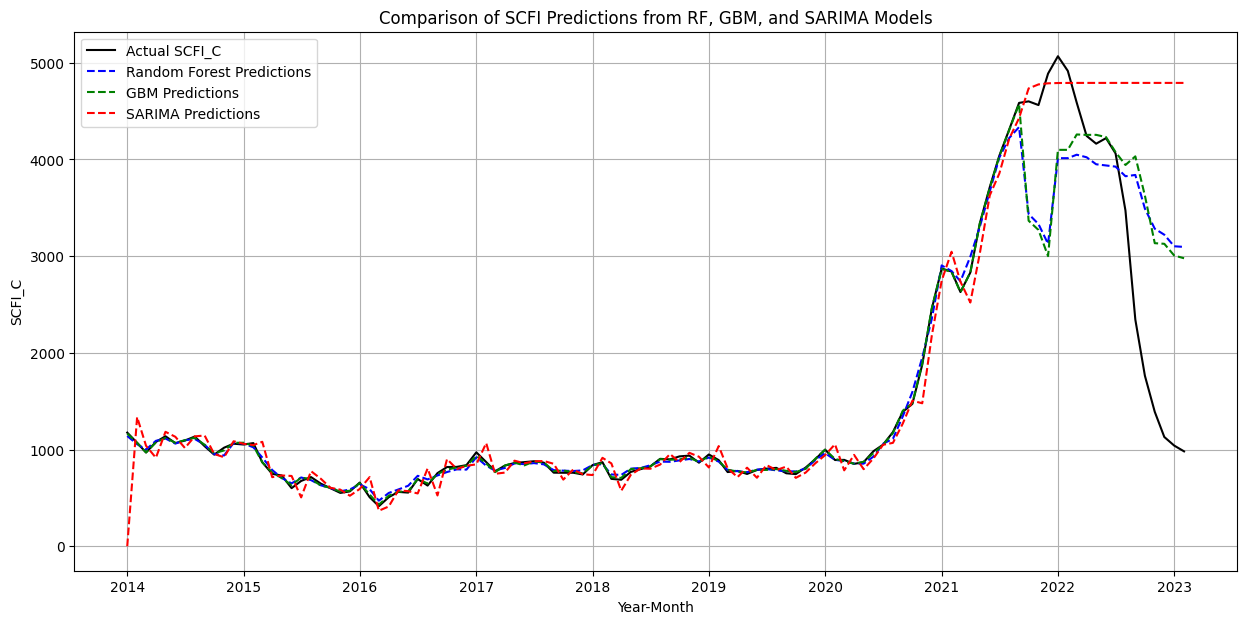

In [6]:
import matplotlib.pyplot as plt

# Generate predictions for the entire dataset using RF and GBM
X_full = data_with_months.drop(['YYYYMM', 'SCFI_C', 'Month'], axis=1)
y_full_pred_rf = rf_model.predict(X_full)
y_full_pred_gbm = gbm_model.predict(X_full)

# Generate predictions for the entire dataset using SARIMAX with the complete date-indexed data
data_time_indexed = data_with_months.set_index(pd.DatetimeIndex(data_with_months['YYYYMM']))
y_full_pred_sarimax = sarimax_result.predict(start=data_time_indexed.index[0], end=data_time_indexed.index[-1])

# Plotting the results
# Plotting the results with corrected legend for SARIMA
plt.figure(figsize=(15, 7))
plt.plot(data_time_indexed.index, data_with_months['SCFI_C'], 'k-', label='Actual SCFI_C')
plt.plot(data_time_indexed.index, y_full_pred_rf, 'b--', label='Random Forest Predictions')
plt.plot(data_time_indexed.index, y_full_pred_gbm, 'g--', label='GBM Predictions')
plt.plot(data_time_indexed.index, y_full_pred_sarimax, 'r--', label='SARIMA Predictions')
plt.title('Comparison of SCFI Predictions from RF, GBM, and SARIMA Models')
plt.xlabel('Year-Month')
plt.ylabel('SCFI_C')
plt.legend()
plt.grid(True)
plt.show()



In [8]:
# Create a DataFrame to display RMSE values in table format
rmse_summary = pd.DataFrame({
    'Model': ['Random Forest', 'GBM', 'SARIMA'],
    'Training RMSE': [rf_train_rmse, gbm_train_rmse, sarimax_train_rmse],
    'Test RMSE': [rf_test_rmse, gbm_test_rmse, sarimax_test_rmse]
})

rmse_summary


,Model,Training RMSE,Test RMSE
0,Random Forest,50.129179,1337.290144
1,GBM,15.239646,1326.110922
2,SARIMA,169.241049,2061.020163


파라미터 튜닝

랜덤포레스트와 GBM 모델의 예측값을 확인할 수 있습니다. 그리고 RMSE 값은 다음과 같습니다

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data with one-hot encoding for months
data['Month'] = pd.to_datetime(data['YYYYMM'], format='%Y-%m').dt.month
month_one_hot = pd.get_dummies(data['Month'], prefix='Month').iloc[:, 1:]  # Exclude January
data_with_months = data.join(month_one_hot)
data_with_months.drop(['Month'], axis=1, inplace=True)  # No longer need the Month column

# Split the data based on date for training and test
test_start_date = '2021-10'
train_data = data_with_months[data_with_months['YYYYMM'] < test_start_date]
test_data = data_with_months[data_with_months['YYYYMM'] >= test_start_date]

# Independent and dependent variables
X_train = train_data.drop(['YYYYMM', 'SCFI_C'], axis=1)
y_train = train_data['SCFI_C']
X_test = test_data.drop(['YYYYMM', 'SCFI_C'], axis=1)
y_test = test_data['SCFI_C']

# Initialize and fit the Random Forest model
rf_model = RandomForestRegressor(
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)
rf_model.fit(X_train, y_train)
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Initialize and fit the GBM model
gbm_model = GradientBoostingRegressor(
    learning_rate=0.2,
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)
gbm_model.fit(X_train, y_train)
y_train_pred_gbm = gbm_model.predict(X_train)
y_test_pred_gbm = gbm_model.predict(X_test)

# Calculate RMSE for training and test sets
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
gbm_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_gbm))
gbm_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_gbm))


(rf_train_rmse, rf_test_rmse, gbm_train_rmse, gbm_test_rmse)


(123.321876096174,
 1116.7156616081138,
 3.121125744066193e-06,
 1416.738286301922)

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare time indexed data for SARIMA modeling
train_data_time_indexed = train_data.set_index(pd.to_datetime(train_data['YYYYMM'], format='%Y-%m'))
test_data_time_indexed = test_data.set_index(pd.to_datetime(test_data['YYYYMM'], format='%Y-%m'))

# Define and fit the SARIMA model with predefined optimal parameters
sarimax_model = SARIMAX(train_data_time_indexed['SCFI_C'],
                        order=(2, 2, 2),
                        seasonal_order=(1, 0, 1, 12),  # Yearly seasonality
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarimax_result = sarimax_model.fit(disp=False)

# Predictions on training and test data
y_train_pred_sarimax = sarimax_result.predict(start=train_data_time_indexed.index[0], end=train_data_time_indexed.index[-1])
y_test_pred_sarimax = sarimax_result.get_forecast(steps=len(test_data_time_indexed)).predicted_mean

# Calculate RMSE for SARIMA model
sarimax_train_rmse = np.sqrt(mean_squared_error(train_data_time_indexed['SCFI_C'], y_train_pred_sarimax))
sarimax_test_rmse = np.sqrt(mean_squared_error(test_data_time_indexed['SCFI_C'], y_test_pred_sarimax))

(sarimax_train_rmse, sarimax_test_rmse)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(205.02587606914975, 5487.67057279348)

# 도표 21-13. 하이퍼파라미터 튜닝 후 3개 모형의 예측 결과 비교

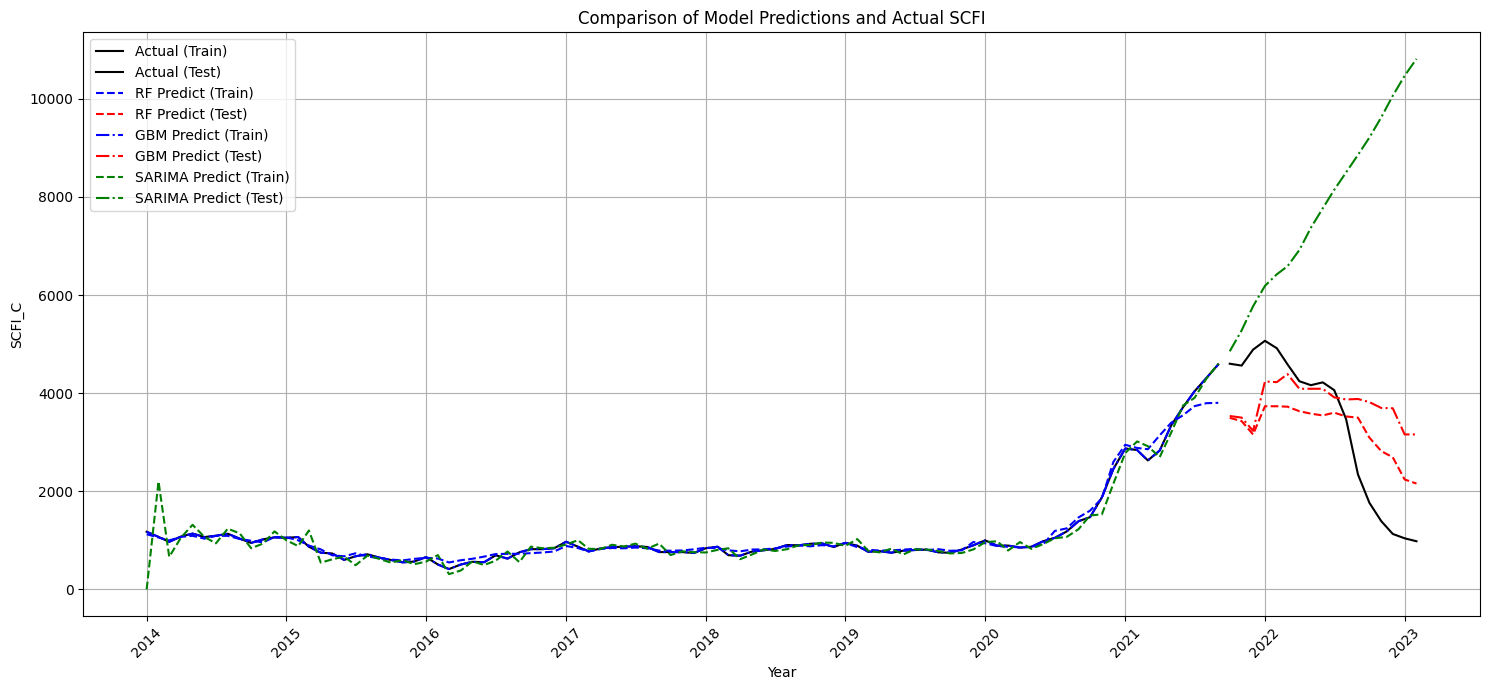

In [12]:
from matplotlib.dates import YearLocator, DateFormatter

# Correct the x-axis to display only the years
plt.figure(figsize=(15, 7))
plt.plot(train_data_time_indexed.index, train_data_time_indexed['SCFI_C'], 'k-', label='Actual (Train)')
plt.plot(test_data_time_indexed.index, test_data_time_indexed['SCFI_C'], 'k-', label='Actual (Test)')

# Random Forest predictions
plt.plot(train_data_time_indexed.index, y_train_pred_rf, 'b--', label='RF Predict (Train)')
plt.plot(test_data_time_indexed.index, y_test_pred_rf, 'r--', label='RF Predict (Test)')

# GBM predictions
plt.plot(train_data_time_indexed.index, y_train_pred_gbm, 'b-.', label='GBM Predict (Train)')
plt.plot(test_data_time_indexed.index, y_test_pred_gbm, 'r-.', label='GBM Predict (Test)')

# SARIMA predictions
plt.plot(train_data_time_indexed.index, y_train_pred_sarimax, 'g--', label='SARIMA Predict (Train)')
plt.plot(test_data_time_indexed.index, y_test_pred_sarimax, 'g-.', label='SARIMA Predict (Test)')

# Set x-axis major ticks to yearly frequency and format to show only the year
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.legend()
plt.title('Comparison of Model Predictions and Actual SCFI')
plt.xlabel('Year')
plt.ylabel('SCFI_C')
plt.grid(True)
plt.tight_layout()

plt.show()


In [13]:
# Create a DataFrame to display RMSE values for training and testing for each model
rmse_data = {
    "Model": ["Random Forest", "Gradient Boosting", "SARIMA"],
    "Train RMSE": [rf_train_rmse, gbm_train_rmse, sarimax_train_rmse],
    "Test RMSE": [rf_test_rmse, gbm_test_rmse, sarimax_test_rmse]
}

rmse_df = pd.DataFrame(rmse_data)

# Display the DataFrame
rmse_df


,Model,Train RMSE,Test RMSE
0,Random Forest,123.321876,1116.715662
1,Gradient Boosting,0.000003,1416.738286
2,SARIMA,205.025876,5487.670573
